# Carregar e pré-processar imagens

Este estudo mostra como carregar e pré-processar um conjunto de dados de imaegns de três formas:

1. Primeiramente, usaremos utilitários de pré-processamento Keras de alto nível (como o [tf.keras.utils.imagem_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory?hl=pt-br)) e camadas (como o [tf.keras.layers.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling?hl=pt-br) para ler um diretório no disco;

2. Depois, escreveremos o nosso próprio pipeline de entrada do zero usando [tf.data](https://www.tensorflow.org/guide/data?hl=pt-br) e;

3. Por dim, faremos o daownload de um conjunto de dados do [grande catálogo](https://www.tensorflow.org/datasets/catalog/overview?hl=pt-br) disponível em [TensorFlow Datasets](https://www.tensorflow.org/datasets?hl=pt-br).

## Configurar

Vamos importar as bibliotecas que serão usadas neste estudo:

In [1]:
# Importar as bibliotecas
import os
import PIL
import pathlib
import PIL.Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Mostrar a versão do TensorFlow
print(tf.__version__)

2.8.2


### Baixar o conjunto de dados de flores

Este estudo utiliza um conjunto de dados de milhares de fotos de flores. Esse conjunto possui 5 subdiretórios, um por clase:

- daisy;
- dandelion;
- roses;
- sunflowers e;
- tulips

In [2]:
# Baixar os dados
url_dados = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
diretorio_dados = tf.keras.utils.get_file(origin=url_dados,
                                          fname='flower_photos',
                                          untar=True)
diretorio_dados = pathlib.Path(diretorio_dados)

228827136/228813984 [==============================] - 2s 0us/step


Com o download completo, devemos ter uma cópia das fotos das flores disponível. Ao todo há 3670 fotos ao total:

In [3]:
# Saber quantas fotos têm no diretório
contador_fotos = len(list(diretorio_dados.glob('*/*.jpg')))
print(contador_fotos)

3670


Cada subdiretório possi imagens da flor correspondente. Abaixo estão algumas rosas:

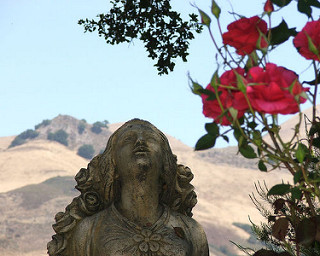

In [4]:
# Ver a primeira foto do diretório "roses/"
rosas = list(diretorio_dados.glob('roses/*'))
PIL.Image.open(str(rosas[0]))

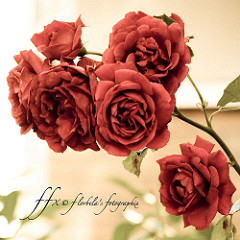

In [5]:
# Ver a segunda foto do diretório "roses/"
rosas = list(diretorio_dados.glob('roses/*'))
PIL.Image.open(str(rosas[1]))

## Carregar os dados usando um utilitário Keras

Vamos carregar as imagens com o utilitário [tf.keras.utils.imagem_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory?hl=pt-br).

### Criar um conjunto de dados

Definiremos alguns parâmetros para o carregador:

In [6]:
# Definir os parâmetros que o carregador usará
tamanho_lote = 32
imagem_altura = 180
imagem_largura = 180

Quando for treinar um modelo, é bom separar alguns dados para a validação. Neste estudo, usaremos 80% das imagens para treino e 20% para a validação do treino:

In [7]:
# Montar o conjunto de dados para o treino
dados_treino = tf.keras.utils.image_dataset_from_directory(
    diretorio_dados,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(imagem_altura, imagem_largura),
    batch_size=tamanho_lote
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
# Montar o conjunto de dados para a validação
dados_validacao = tf.keras.utils.image_dataset_from_directory(
    diretorio_dados,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(imagem_altura, imagem_largura),
    batch_size=tamanho_lote
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Podemos encontrar os nomes das classes pelo atributo **class_name** no conjunto de dados:

In [9]:
# Obter o nome das classes
nome_classes = dados_treino.class_names
print(nome_classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualizar os dados

Abaixo estão as 9 primeiras imagens do conjunto de treino:

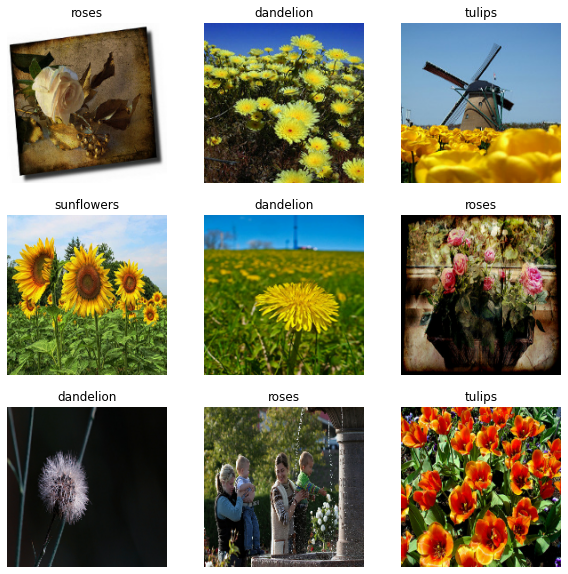

In [10]:
# Plotar as 9 primeiras imagens do conjunto de treino
plt.figure(figsize=(10, 10))
for imagens, rotulos in dados_treino.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(imagens[i].numpy().astype('uint8'))
        plt.title(nome_classes[rotulos[i]])
        plt.axis('off')

Podemos treinar um modelo utilizando esses conjuntos de dados passando-os para o método **fit()**. Podemos também iterar manualmente no conjunto de dados e recuperar lotes de imagens:

In [11]:
# Obter os lotes das imagens
for imagem_lote, rotulo_lote in dados_treino:
    print(imagem_lote.shape)
    print(rotulo_lote.shape)
    break

(32, 180, 180, 3)
(32,)


A `imagem_lote` é um tensor da forma `(32, 180, 180, 3)`. Este é um lote de 32 imagens de formato 180x180x3 (o último canal é referente as cores RGB). O `rotulo_lote` é um tensor da forma `(32,)`, estes são os rótlos correspondetes às 32 imagens.

Podemos chamar o método **numpy()** em qualquer um desses tensores para convertê-los em um **numpy.ndarray**.

### Padronizar os dados

Os valores do canal RGB estão na faixa de 0 a 255. Isso não é o ideal para uma rede neural; de modo geral, devemos tornar os valores de entrada pequenos.

Para isso, padronizaremos os valores para o intervalo de 0 a 1 com o [tf.keras.layers.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling?hl=pt-br):

In [12]:
# Padronizar a entrada de cor
camada_normalizacao = tf.keras.layers.Rescaling(1./255)

Há dois modos de utilizar essa camada. Podemos aplicá-la ao conjunto de dados chamando a função [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br#map):

In [13]:
# Passar a normalização para os dados
dados_normalizados = dados_treino.map(lambda x, y: (camada_normalizacao(x), y))
imagem_lote, rotulo_lote = next(iter(dados_normalizados))
primeira_imagem = imagem_lote[0]

# Mostrar que os valores dos pixels estão entre 0 e 1
print(np.min(primeira_imagem), np.max(primeira_imagem))

0.0 0.96902645


A segunda opção (que será a que usaremos) é incluir a camada dentro da definição de modelo para simplificar a implantação.

### Configurar o conjunto de dados para o desempenho

Vamos nos certificar de usar a busca prévia em buffer para que possamos produzir dados do disco sem qe a entrada/saída se torne um bloqueio. Estes são dois métodos importantes que devemos utilizar ao carregar os dados:

- [cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br#cache) mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época. Isso assegurará que o conjunto de dados não seja um gargalo ao treinar o modelo. Se o conjunto for grande demais para a memória, poderemos usar esse método para criar um cache em disco de alto desempenho.

- [prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br#prefetch) sobrepõe o processamento prévio de dados e a execução do modelo durante o treino.

Para aprender mais sobre os dois métodos acima, acesse o guia [Melhor desempenho com a API tf.data](https://www.tensorflow.org/guide/data_performance?hl=pt-br):

In [14]:
# Busca prévia do buffer
AUTO_AJUSTE = tf.data.AUTOTUNE
dados_treino = dados_treino.cache().prefetch(buffer_size=AUTO_AJUSTE)
dados_validacao = dados_validacao.cache().prefetch(buffer_size=AUTO_AJUSTE)

### Treinar um modelo

Para finalizar o tópico, vejamos como treinar um modelo simples com os dados que preparamos.

O modelo [Sequential](https://www.tensorflow.org/guide/keras/sequential_model?hl=pt-br) consiste em três blobos de convolução ([tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D?hl=pt-br) com um camada de agrupamento máximo ([tf.keras.layers.MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D?hl=pt-br)) em cada um delos. Ainda há uma camada totalmente conectada ([tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?hl=pt-br)) com 128 neurônios em cima dela que é ativada por uma função de ativação **ReLU** (`'relu'`). Este modelo não foi ajustado, o objetivo é mostrar a mecânica usada com os conjuntos de dados que acabamos de tratar. Para saber mais sobre a classificação de imagens, veja esse [tutorial](https://www.tensorflow.org/tutorials/images/classification?hl=pt-br):

In [15]:
# Criar o modelo
quantidade_classes = 5

modelo = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(quantidade_classes)
])

Escolher o otimizador [tf.keras.optimizer.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?hl=pt-br) e a função de perda [tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?hl=pt-br). Para analisar a precisão do treino e da validação para cada época de treino, chame do método **compile()** do modelo:

In [16]:
# Compilar o modelo
modelo.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Agora vamos treinar o nosso modelo:

In [17]:
# Treinar o modelo
modelo.fit(
    dados_treino,
    validation_data=dados_validacao,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 133s 1s/step - loss: 1.2923 - accuracy: 0.4366 - val_loss: 1.0861 - val_accuracy: 0.5627
Epoch 2/3
92/92 [==============================] - 109s 1s/step - loss: 1.0498 - accuracy: 0.5705 - val_loss: 1.0280 - val_accuracy: 0.5926
Epoch 3/3
92/92 [==============================] - 110s 1s/step - loss: 0.8859 - accuracy: 0.6618 - val_loss: 0.9645 - val_accuracy: 0.6308


Podemos notar que a acurácia da validação é baixa em comparação com a do treino, o que indica que o modelo está sobreajustado.

## Usar o tf.data para um controle mais preciso


O utilitário de pré-processamento visto acima ([tf.keras.utils.imagem_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory?hl=pt-br)) é um modo conveniente de criar um [tf.data.Datset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br) a partir de um diretório de imagens.

Para um controle de granulação mais preciso, podemos escrever um pipeline de entrada com o [tf.data](https://www.tensorflow.org/api_docs/python/tf/data?hl=pt-br). Esta parte do estudo mostra como desenvolver esse pipeline, começando com os caminhos dos arquivos TGZ que baixamos no começo:

In [18]:
# Armazenar as imagens em uma lista
lista_dados = tf.data.Dataset.list_files(str(diretorio_dados/'*/*'),shuffle=False)
lista_dados = lista_dados.shuffle(contador_fotos, reshuffle_each_iteration=False)

In [19]:
# Mostrar os 5 primeiros itens da lista
for arquivo in lista_dados.take(5):
    print(arquivo.numpy())

b'/root/.keras/datasets/flower_photos/dandelion/14126515096_1134fae695.jpg'
b'/root/.keras/datasets/flower_photos/daisy/4141147800_813f660b47.jpg'
b'/root/.keras/datasets/flower_photos/roses/22679076_bdb4c24401_m.jpg'
b'/root/.keras/datasets/flower_photos/tulips/15275199229_962387f24d.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/14646282112_447cc7d1f9.jpg'


A estrutura em árvore dos arquivos poderá ser utilizada para compilar uma lista de **nome_classes**:

In [20]:
# Armazenar em o nome das classes em um array
nome_classes = np.array(sorted([item.name for item in diretorio_dados.glob('*') if item.name != 'LICENSE.txt']))
print(nome_classes)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Dividiremos o conjunto de dados em conjunto de treino e validação:

In [21]:
# Separar os dados em treino e validação
tamanho_validacao = int(contador_fotos * 0.2)
dados_treino = lista_dados.skip(tamanho_validacao)
dados_validacao = lista_dados.take(tamanho_validacao)

Podemos mostrar o comprimento de cada conjunto de dados da seguinte maneira:

In [22]:
# Mostrar o tamanho de cada conjunto de dados
print(tf.data.experimental.cardinality(dados_treino).numpy())
print(tf.data.experimental.cardinality(dados_validacao).numpy())

2936
734


Escreveremos agora uma função curta que converta um caminho de arquivo em um par `(imagem, rotulo)`:

In [23]:
# Criar a função para retornar o rótulo
def obter_rotulo(caminho_arquivo):
    # Converter o caminho para uma lista com os componentes do caminho
    partes_caminho = tf.strings.split(caminho_arquivo, os.path.sep)

    # O penúltimo item do caminho é o diretório da classe
    one_hot = partes_caminho[-2] == nome_classes
    
    # Um inteiro codifica o rótulo
    return tf.argmax(one_hot)

In [24]:
# Criar a função para retornar a imagem
def decodificar_imagem(imagem):
    # Converter a string para um tensor 3D uint8
    imagem = tf.io.decode_jpeg(imagem, channels=3)

    # Redimenzionar a imagem para o tamanho desejado
    return tf.image.resize(imagem, [imagem_altura, imagem_largura])

In [25]:
# Criar a função que retorna o par (imagem, rótulo)
def caminho_processado(caminho_arquivo):
    rotulo = obter_rotulo(caminho_arquivo)

    # Carregar o dado bruto do arquivo como uma string
    imagem = tf.io.read_file(caminho_arquivo)
    imagem = decodificar_imagem(imagem)

    # Retornar o par (imagem, rotulo)
    return imagem, rotulo

Usaremos [Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br#map) oara criar um conjunto de dados de `(imagem, rótulo)`:

In [26]:
# Configurar "num_parallel_calls" para que várias imagens possam ser carregadas/processadas em paralelo
dados_treino = dados_treino.map(caminho_processado, num_parallel_calls=AUTO_AJUSTE)
dados_validacao = dados_validacao.map(caminho_processado, num_parallel_calls=AUTO_AJUSTE)

In [27]:
# Ver as imagens estão dimensionadas e a classe que pertencem
for imagem, rotulo in dados_treino.take(1):
    print(f'''Dimensões imagem: {imagem.numpy().shape}
Rótulo: {rotulo}''')

Dimensões imagem: (180, 180, 3)
Rótulo: 1


### Configurar o conjunto de dados para desempenho

Para treinar um modelo com o conjunto de dados, precisaremos que os conjuntos possuam as seguintes características:

- Bem embaralhado;

- Ser em lote e;

- Os lotes precisam ser disponibilizados o mais rápido possível.

Esses recursos pode ser usados com a API [tf.data](https://www.tensorflow.org/api_docs/python/tf/data?hl=pt-br). Para mais detalhes, veja esse [tutorial](https://www.tensorflow.org/guide/data_performance?hl=pt-br):

In [28]:
# Criar a função par configurar as características dos conjuntos
def configurar_performance(conjunto_dados):
    conjunto_dados = conjunto_dados.cache()
    conjunto_dados = conjunto_dados.shuffle(buffer_size=1000)
    conjunto_dados = conjunto_dados.batch(tamanho_lote)
    conjunto_dados = conjunto_dados.prefetch(buffer_size=AUTO_AJUSTE)
    return conjunto_dados

In [29]:
# Configurar a performance dos conjuntos
dados_treino = configurar_performance(dados_treino)
dados_validacao = configurar_performance(dados_validacao)

### Visualizar os dados

Podemos visualizar os dados em um gráfico como fizemos no começo do estudo:

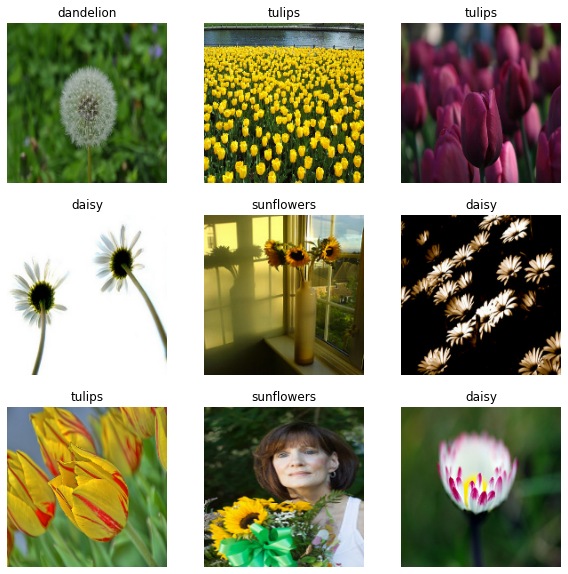

In [30]:
# Visualizar como os dados estão no conjunto
lote_imagem, lote_rotulo = next(iter(dados_treino))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(lote_imagem[i].numpy().astype('uint8'))
    rotulo = lote_rotulo[i]
    plt.title(nome_classes[rotulo])
    plt.axis('off')

### Continuar com o treinamento do modelo

Contruimos agora manualmente um [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?hl=pt-br) semelhante ao criado pelo TensorFlow. Podemos continuar com o treino do modelo com o conjunto construído manualmente. Como antes, utilizaremos poucas épocas para manter o tempod de execução curto:

In [31]:
# Treinar o modelo
modelo.fit(dados_treino,
           validation_data=dados_validacao,
           epochs=3)

Epoch 1/3
92/92 [==============================] - 120s 1s/step - loss: 0.7643 - accuracy: 0.7016 - val_loss: 0.7696 - val_accuracy: 0.7166
Epoch 2/3
92/92 [==============================] - 111s 1s/step - loss: 0.5389 - accuracy: 0.8099 - val_loss: 0.8196 - val_accuracy: 0.7207
Epoch 3/3
92/92 [==============================] - 111s 1s/step - loss: 0.3522 - accuracy: 0.8791 - val_loss: 0.7978 - val_accuracy: 0.7248


## Como utilizar conjuntos de dados do TensorFlow

Vimos até agora neste estudo o carregamento de dados do disco. Podemos encontrar também um conjunto de dados para explorar a [grade catálogo](https://www.tensorflow.org/datasets/catalog/overview?hl=pt-br) de conjuntos de dados fáceis de baixar em [TensorFlow DataSets](https://www.tensorflow.org/datasets?hl=pt-br).

Como já carregamos o conjunto no começo do estudo no disco, vamos agora importar esse mesmo conjunto do TensorFlow.

Faremos o download do [conjunto de dados](https://www.tensorflow.org/datasets/catalog/tf_flowers?hl=pt-br):

In [34]:
# Baixar o conjunto de dados pelo TensorFlow
(dados_treino, dados_validacao, dados_teste), metadado = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

O conjunto de dados possui 5 classes:

In [36]:
# Ver a quantidade de classes do conjunto de dados
quantidade_classes = metadado.features['label'].num_classes
print(quantidade_classes)

5


Vamos recuperar uma imagem desse conjunto:

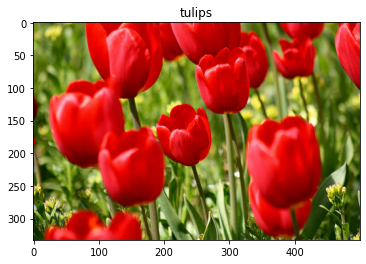

In [37]:
# Mostrar uma imagem do conjunto
nome_rotulo = metadado.features['label'].int2str
imagem, rotulo = next(iter(dados_treino))
plt.figure()
plt.title(nome_rotulo(rotulo))
plt.imshow(imagem)

Como fizemos anteriormente, devemos agrupar, embaralhar e configurar os conjuntos de treino, validação e teste para desempenho:

In [38]:
# Configurar os dados
dados_treino = configurar_performance(dados_treino)
dados_validacao = configurar_performance(dados_validacao)
dados_teste = configurar_performance(dados_teste)

Podemos encontrar um exemplo completo de como trabalhar com esse conjunto de dados e o TensorFlow Dataset nesse [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=pt-br).

## Próximos passos

Este estudo apresentou duas formas de carregar imagens do disco. Primeiramente, aprendemos a carregar e pré-processar um conjunto de dados de imagens utilizando camadas e utilitários de pré-processamento Keras. Depois, aprendemos a escrever um pipeline de entrada do zero com o [tf.data](https://www.tensorflow.org/api_docs/python/tf/data?hl=pt-br). Ao final, aprendemos a baixar um conjunto de dados do TensorFlow Dataset.

Para as próximas etapas:

- Estdar como adicionar [aumento de dados](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=pt-br).

- Para aprender mais sobre o [tf.data](https://www.tensorflow.org/api_docs/python/tf/data?hl=pt-br), veja esse [guia](https://www.tensorflow.org/guide/data?hl=pt-br).